In [1]:
import torch.utils.data as data
import PIL
from PIL import Image
import numpy as np
import skimage.io as io
import os

class PinkEyes(data.Dataset):
    
    def __init__(self,
             dataset_base_folder_path='/home/daniil/repos/pink/dataset/',
             train=True,
             joint_transform=None,
             number_of_images=1500):
        
        self.joint_transform = joint_transform
        self.train = train
        if train:
            self.dataset_base_folder_path = dataset_base_folder_path + 'train/'
            
        else:
            
            self.dataset_base_folder_path = dataset_base_folder_path + 'test/'
        
        self.images_folder_path = self.dataset_base_folder_path + 'images/'
        self.annotations_folder_path = self.dataset_base_folder_path + 'annotations/'
        self.filenames = list( map(lambda x: x[:-4], os.listdir(self.images_folder_path)[:number_of_images] ) )
    
    def __len__(self):
        
        return len(self.filenames)
                              
    def __getitem__(self, index):
        
        filename = self.filenames[index]
        image_path = self.images_folder_path + filename + '.png'
        annotation_path = self.annotations_folder_path + filename + '.png'
        image = Image.open(image_path)#.resize((512, 512), PIL.Image.BILINEAR)
        annotation = np.asarray(Image.open(annotation_path)).copy()
        annotation[annotation > 0] = 1
        annotation = Image.fromarray(annotation[:, :, 0])

        if self.joint_transform is not None:

            image, annotation = self.joint_transform([image, annotation])

        return image, annotation

In [2]:
seto = PinkEyes()

In [14]:
img, anno = seto[25]

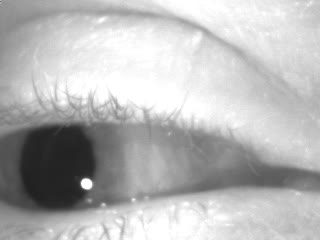

In [15]:
img

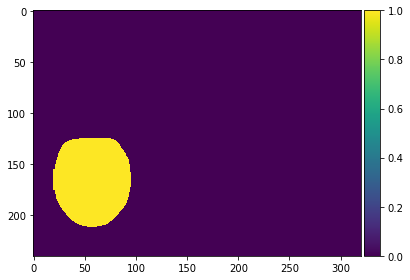

In [16]:
io.imshow(np.asarray(anno))

In [2]:
#%matplotlib inline

import sys, os
sys.path.insert(0, 'pytorch-segmentation-detection/vision/')
sys.path.append('pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.layers import GlobalAvgPool2d

import numpy as np
import torch.nn as nn

#from pytorch_segmentation_detection.datasets.openeds import OpenEDS

import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)

from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim

from pytorch_segmentation_detection.metrics import RunningConfusionMatrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

def adjust_learning_rate(optimizer, iteration):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    max_iteration = 4000.0
    
    multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
    
    lr = 0.0001 * multiplier
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



from pytorch_segmentation_detection.transforms import RandomCropJoint

number_of_classes = 2

labels = range(number_of_classes)

In [3]:

train_transform = ComposeJoint(
                [
                    # Crop to the actual view of the endoscop camera
                    #[transforms.CenterCrop((1024, 1280)), transforms.CenterCrop((1024, 1280))],
                    #RandomScaleJoint(low=0.5, high=2.0),
                    #RandomCropJoint(crop_size=(512, 512)),
                    #RandomHorizontalFlipJoint(),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

# trainset = Endovis_Instrument_2017_fast(root='/home/daniil/.pytorch-segmentation-detection/datasets/endovis_2017/',
#                                         dataset_type=0,
#                                         joint_transform=train_transform)

trainset = PinkEyes(train=True, joint_transform=train_transform)

# trainset = OpenEDS(dataset_base_folder_path='',
#                    csv_folds_file='split.csv',
#                    train=True,
#                    fold_number=0,
#                    joint_transform=train_transform)

# trainset = HairDataset(dataset_root=dataset_root,
#                        joint_transform=train_transform,
#                        train=True)


trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=False,
                                          drop_last=True)



valid_transform = ComposeJoint(
                [
                     #[transforms.CenterCrop((1024, 1280)), transforms.CenterCrop((1024, 1280))],
                     #RandomCropJoint(crop_size=(512, 512)),
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = PinkEyes(train=False, joint_transform=valid_transform, number_of_images=500)

# valset = OpenEDS(dataset_base_folder_path='',
#                    csv_folds_file='split.csv',
#                    train=False,
#                    fold_number=0,
#                    joint_transform=valid_transform)

valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2, pin_memory=False)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(range(223))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)


# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union


def validate_train():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in train_subset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union

<IPython.core.display.Javascript object>


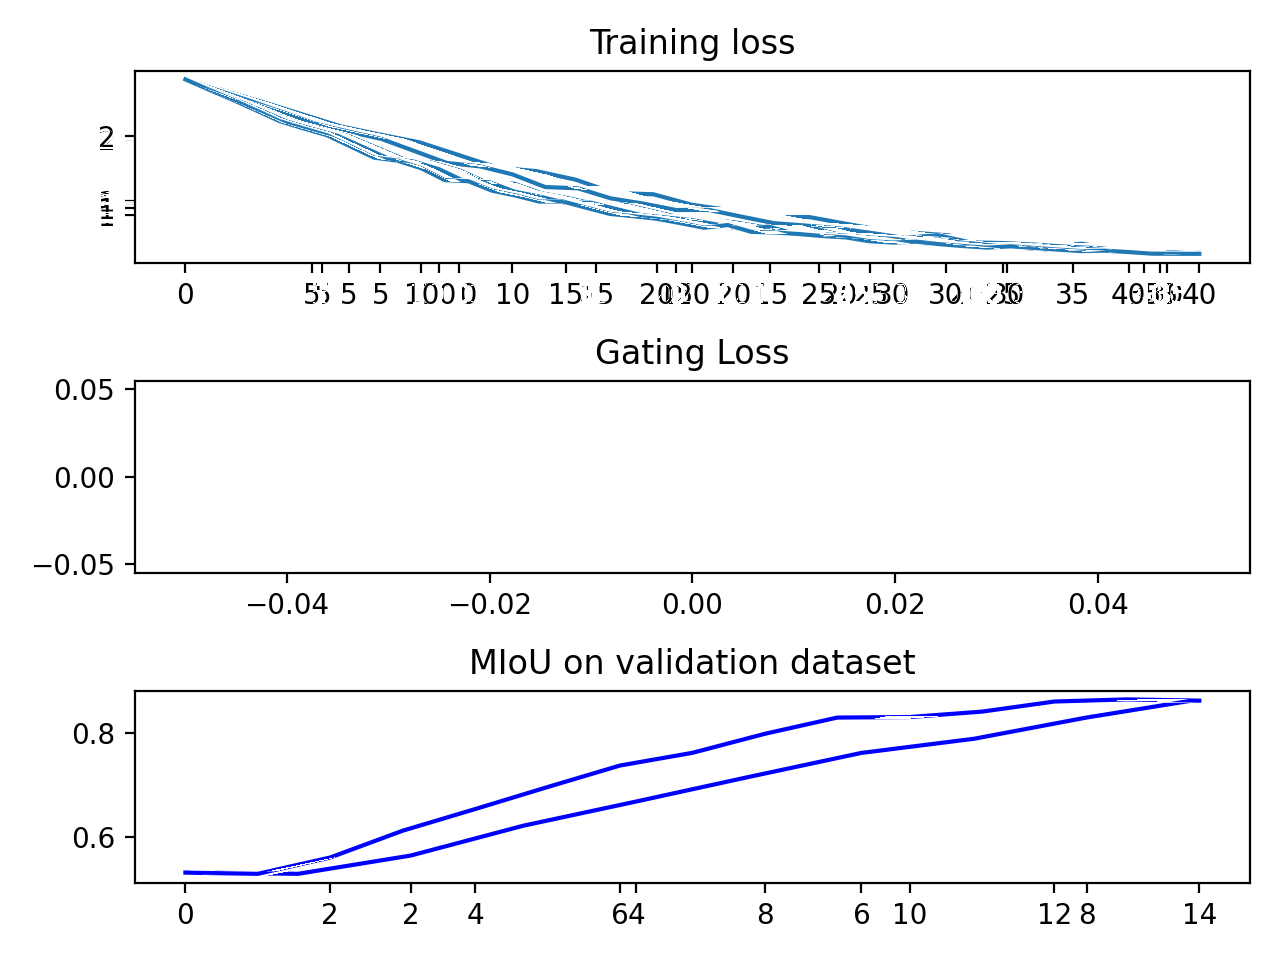

In [4]:
%matplotlib notebook

from matplotlib import pyplot as plt


# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []


train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []

gating_loss_current_iteration = 0
gating_loss_history = []
gating_loss_iteration_number_history = []
 
f, (loss_axis, gating_loss_axis, validation_axis) = plt.subplots(3, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
gating_loss_axis.plot(gating_loss_iteration_number_history, gating_loss_history)

validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')
gating_loss_axis.set_title('Gating Loss')

plt.tight_layout()

<IPython.core.display.Javascript object>


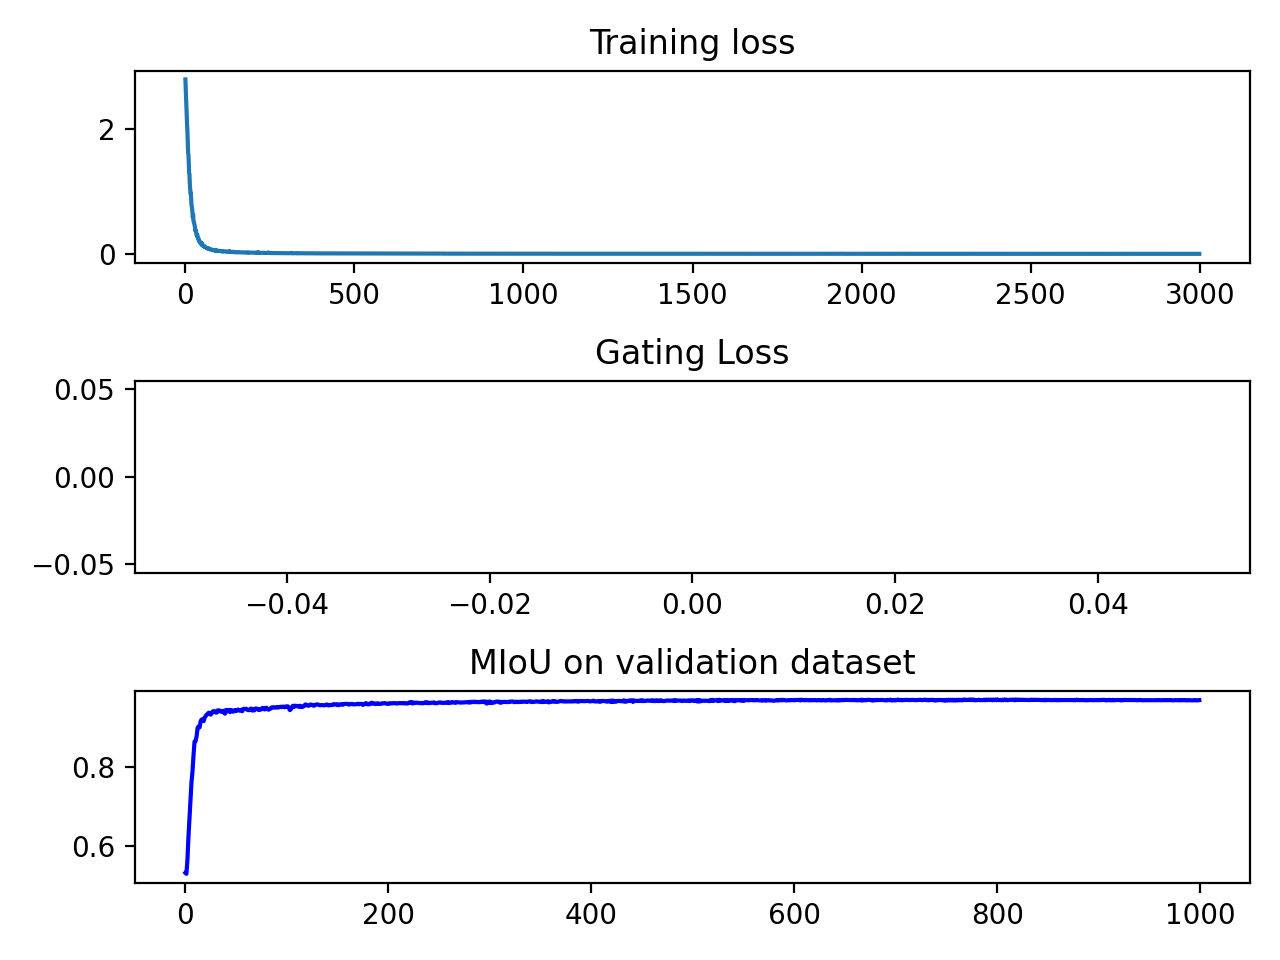

In [7]:
f, (loss_axis, gating_loss_axis, validation_axis) = plt.subplots(3, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
gating_loss_axis.plot(gating_loss_iteration_number_history, gating_loss_history)

validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')
gating_loss_axis.set_title('Gating Loss')

plt.tight_layout()

In [5]:
fcn = resnet_dilated.Resnet18_8s(num_classes=19)

fcn.cuda()
fcn.train()

classification_criterion = nn.CrossEntropyLoss(size_average=True, ignore_index=255).cuda()

#optimizer = optim.Adam(fcn.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/home/daniil/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
from pytorch_segmentation_detection.utils.batchnorm import adjust_bn_layers_to_compute_populatin_stats, restore_original_settings_of_bn_layers
from sklearn.metrics import confusion_matrix

best_validation_score = 0
loss_current_iteration = 0


for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_gate = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        img, anno = data
        
        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno = Variable(img.cuda()), Variable(anno.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        final_logits = fcn(img)
        
        classification_loss = classification_criterion(final_logits, anno)
        
        loss = classification_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(classification_loss.item())
        loss_iteration_number_history.append(loss_current_iteration)
            
        loss_current_iteration += 1

        loss_axis.lines[0].set_xdata(loss_iteration_number_history)
        loss_axis.lines[0].set_ydata(loss_history)

        loss_axis.relim()
        loss_axis.autoscale_view()
        loss_axis.figure.canvas.draw()
        
        adjust_learning_rate(optimizer, loss_current_iteration)
        

    if (epoch + 1) % 1 == 0:
        
#         fcn.apply(adjust_bn_layers_to_compute_populatin_stats)
#         for i in range(2): 
#             with torch.no_grad():
#                 for batch_idx, (inputs, targets) in enumerate(trainloader):
#                     _ = fcn(inputs.cuda())
#         fcn.apply(restore_original_settings_of_bn_layers)
        
        with torch.set_grad_enabled(False):
            
            current_validation_score = validate()
            
        validation_history.append(current_validation_score)
        validation_iteration_number_history.append(validation_current_iteration)

        validation_current_iteration += 1

        validation_axis.lines[0].set_xdata(validation_iteration_number_history)
        validation_axis.lines[0].set_ydata(validation_history)


        validation_axis.relim()
        validation_axis.autoscale_view()
        validation_axis.figure.canvas.draw()

        # Save the model if it has a better MIoU score.
        if current_validation_score > best_validation_score:

            torch.save(fcn.state_dict(), 'resnet_18_8s_pink_eyes.pth')
            best_validation_score = current_validation_score
            print(best_validation_score)
        
                

print('Finished Training')

<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.5321953649251772


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.5648081546345946


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.6223534750718893


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.668879553616589


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.7162383669767914


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.7625443738999556


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.7898355690730554


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.8307511497566149


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.8656940803550449


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.866897810523632


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.8784988363457531


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.9002525530474711


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t

0.9048123424383585


<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
<ipython-input-3-61a1e42a226b>:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for t